# Fläche der Feuchtgebiete aus der Biotopkartierung der Stadt Zürich 
Datum: 7.1.2022

Im Rahmen der Zahl der Woche suchen wir im Rahmen des [**«Welttags der Feuchtgebiete»**](https://commons.wikimedia.org/wiki/Category:World_Wetlands_Day?uselang=de) avom 2. Februar die Fläche der Feuchtgebiete in der Stadt Zürich.

Dazu wollen wir die frei verfügbaren Geodaten «[Biotopkartierung 2020](https://www.stadt-zuerich.ch/geodaten/download/Biotoptypenkartierung_2020)» auf dem Geoportal der Stadt Zürich verwenden.

Die [Metadaten dazu](https://www.geocat.ch/geonetwork/srv/ger/md.viewer#/full_view/d8f100e5-c749-48b6-b84b-ffde315e0308) sind auf GeoCat ersichtlich


Mit Colab kann **dieses Jupyter-Notebook interaktiv im Browser** gestartet werden:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DonGoginho/myPy/blob/main/biotopkartierung/.ipynb_checkpoints/zdw_feuchtgebiete-checkpoint.ipynb)


## Importiere notwendige Packages:

In [48]:
%pip install geopandas fiona requests folium mplleaflet contextily pivottablejs

In [134]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import folium
import mplleaflet

import pivottablejs
from pivottablejs import pivot_ui


import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)


pd.options.display.float_format = '{:.1f}'.format
#pd.set_option('display.width', 100)
#pd.set_option('display.max_columns', 15)

## Lies die Daten ein


### Direkter Download aller Biotopdaten via WFS

Dauert allerdings eine Weile...

In [135]:
#Direkter GeoJSON-Import via WFS-GeoJSON-Service

geojson_url = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Biotoptypenkartierung_2020?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=btk_2020"
#imp_gdf_biotopkartierung_2020 = gpd.read_file(geojson_url)

In [136]:
imp_gdf_biotopkartierung_2020_lv95 = imp_gdf_biotopkartierung_2020.to_crs(epsg=2056)
imp_gdf_biotopkartierung_2020_lv95.crs

<Projected CRS: EPSG:2056>
Name: CH1903+ / LV95
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1995
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [137]:
rename_cols = {'objid': 'test'}
columns_to_drop = ['struktur_keine']

gdf_biotopkartierung_2020_lv95 = imp_gdf_biotopkartierung_2020_wgs84 \
    .copy() \
    .drop(columns_to_drop, axis=1) \
    .rename(columns=rename_cols) \
    .assign(
        flaeche = lambda x: x.area
     )

gdf_biotopkartierung_2020_lv95.head(2)

,id,biotoptypenqualitaet,feuchtigkeit,legende_lebensraeume,lrtyp1code,lrtyp1text,lrtyp2code,lrtyp2text,lrtyp3code,lrtyp3text,...,struktur_staudig,umsetzung,vernetzungstyp_feucht,vernetzungstyp_gehoelz,vernetzungstyp_offen,vernetzungstyp_trocken,vernetzungstyp_unbekannt,versiegelung,geometry,flaeche
0,btk_2020.1,4,unbekannt,Wald,01,Wälder,01.00,Wald allgemein,01.00.00,Wald allgemein,...,-,keine,-,ja,-,-,-,unversiegelt,"MULTIPOLYGON (((2682258.133 1242456.271, 26822...",7744.1
1,btk_2020.2,4,unbekannt,Wald,01,Wälder,01.00,Wald allgemein,01.00.00,Wald allgemein,...,-,keine,-,ja,-,-,-,unversiegelt,"MULTIPOLYGON (((2682422.082 1242365.591, 26824...",25187.4


##### Speichere das so berechnete Dataframe auch als Geopackage

In [138]:
#Import mit Geopandas, Webseite: https://geopandas.org/docs/user_guide/io.html oder  import fiona; help(fiona.open)
output = r"\\szh\ssz\data\GIS\Sandbox\2022\ZdW\feuchtgebiete\geodata\\"

gdf_biotopkartierung_2020_lv95.to_file(output+r"\biotopkartierung_2020.gpkg", layer='biotopkartierung_2020', driver="GPKG")
print('done')


done


#### Selektiere die Feuchtgebiete

In [139]:
rename_cols = {'objid': 'test'}
columns_to_drop = []

gdf_feuchtgebiete_biotopkartierung_2020_lv95 = gdf_biotopkartierung_2020_lv95 \
    .query("legende_lebensraeume == 'Feuchtgebiete'") \
    .drop(columns_to_drop, axis=1) \
    .rename(columns=rename_cols) \
    .assign()

gdf_feuchtgebiete_biotopkartierung_2020_lv95.head(2)



,id,biotoptypenqualitaet,feuchtigkeit,legende_lebensraeume,lrtyp1code,lrtyp1text,lrtyp2code,lrtyp2text,lrtyp3code,lrtyp3text,...,struktur_staudig,umsetzung,vernetzungstyp_feucht,vernetzungstyp_gehoelz,vernetzungstyp_offen,vernetzungstyp_trocken,vernetzungstyp_unbekannt,versiegelung,geometry,flaeche
3368,btk_2020.3347,6,feucht,Feuchtgebiete,05,"Gehölzfreie Biotope der Sümpfe, Flachmoore und...",05.03,Grossegenried,05.03.03,Grosseggenried mit Sumpf-Segge (ZH: 3c),...,ja,Potenziell inventarwürdig,ja,-,ja,-,-,unversiegelt,"MULTIPOLYGON (((2680822.021 1254020.686, 26808...",1775.9
3369,btk_2020.3348,6,feucht,Feuchtgebiete,05,"Gehölzfreie Biotope der Sümpfe, Flachmoore und...",05.03,Grossegenried,05.03.03,Grosseggenried mit Sumpf-Segge (ZH: 3c),...,ja,Potenziell inventarwürdig,ja,-,ja,-,-,unversiegelt,"MULTIPOLYGON (((2680640.396 1253971.953, 26806...",352.3


## Explorative_Analyse
One of the main objectives of this notebook is to do an exploratory data analysis to understand which questions this data set can answer. In addition, also determine its limitations. 

To begin, let us get the number of unique values per feature.


In [146]:
#gdf_feuchtgewaesser_biotopkartg2020.apply(lambda x: x.unique().size, axis=0)


In [147]:
gdf_biotopkartierung_2020_lv95.apply(lambda x: x.unique().size, axis=0)

id                          91421
biotoptypenqualitaet            7
feuchtigkeit                    4
legende_lebensraeume           16
lrtyp1code                     10
lrtyp1text                     10
lrtyp2code                     62
lrtyp2text                     62
lrtyp3code                    148
lrtyp3text                    148
naehrstoffe                     4
objectid                    91421
struktur_baeume                 2
struktur_buesche                2
struktur_niedrig                2
struktur_staudig                2
umsetzung                       4
vernetzungstyp_feucht           2
vernetzungstyp_gehoelz          2
vernetzungstyp_offen            2
vernetzungstyp_trocken          2
vernetzungstyp_unbekannt        2
versiegelung                    4
geometry                    91421
flaeche                     91420
dtype: int64

<AxesSubplot:>

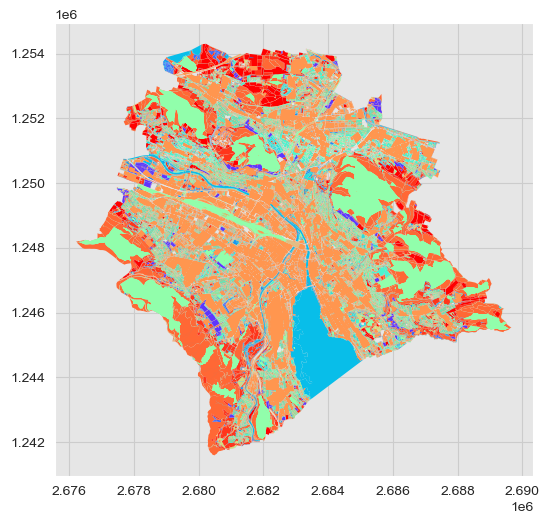

In [148]:
gdf_biotopkartierung_2020_lv95.plot("legende_lebensraeume", cmap="rainbow", legend=False, linestyle='-', linewidth=0)

<AxesSubplot:>

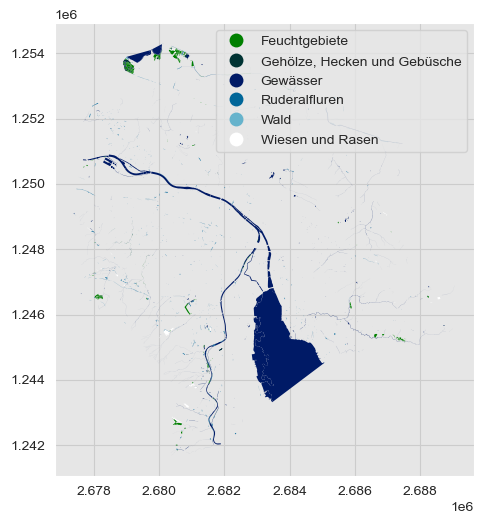

In [149]:
#gdf_biotopkartierung_2020_lv95.query("legende_lebensraeume == 'Feuchtgebiete' | legende_lebensraeume == 'Ruderalfluren'| legende_lebensraeume == 'Gewässer'").plot("legende_lebensraeume", cmap="ocean", legend=False, linestyle='-', linewidth=0)
gdf_biotopkartierung_2020_lv95.query("feuchtigkeit == 'feucht'").plot("legende_lebensraeume", cmap="ocean", legend=True, linestyle='-', linewidth=0)


### Flächen nach Kategorien

Exploriere die Daten mit Pivottable.JS

In [150]:
from pivottablejs import pivot_ui

pivot_ui(gdf_biotopkartierung_2020_lv95)

#### Hauptflächen der gesamten Kartierung
Unterscheidung nach «Legende Lebensräume»

In [151]:
df = gdf_biotopkartierung_2020_lv95 \
    .groupby(['legende_lebensraeume']) \
    .agg(sum_area=('flaeche', 'sum')) \
    .sort_values('legende_lebensraeume', ascending=True) 

df.reset_index()

,legende_lebensraeume,sum_area
0,Beete und Rabatten,88777.6
1,Familiengärten,1571613.9
2,Feuchtgebiete,280252.2
3,"Gehölze, Hecken und Gebüsche",4062020.4
4,Gewässer,5191714.7
5,Grünanlagen,1139922.7
6,Grünanlagen von Mehrfamilienhäusern,8345866.9
7,Gärten,5753284.5
8,Kies- und Schotterflächen,2529042.1
9,Mauern,3254.3


In [159]:
gdf_feuchtgebiete = gdf_biotopkartierung_2020_lv95.query("legende_lebensraeume == 'Feuchtgebiete'")
gdf_feuchtgebiete.head(1)

,id,biotoptypenqualitaet,feuchtigkeit,legende_lebensraeume,lrtyp1code,lrtyp1text,lrtyp2code,lrtyp2text,lrtyp3code,lrtyp3text,...,struktur_staudig,umsetzung,vernetzungstyp_feucht,vernetzungstyp_gehoelz,vernetzungstyp_offen,vernetzungstyp_trocken,vernetzungstyp_unbekannt,versiegelung,geometry,flaeche
3368,btk_2020.3347,6,feucht,Feuchtgebiete,05,"Gehölzfreie Biotope der Sümpfe, Flachmoore und...",05.03,Grossegenried,05.03.03,Grosseggenried mit Sumpf-Segge (ZH: 3c),...,ja,Potenziell inventarwürdig,ja,-,ja,-,-,unversiegelt,"MULTIPOLYGON (((2680822.021 1254020.686, 26808...",1775.9


#### Feuchtgebiete. Unterteilungen

In [158]:
gdf_biotopkartierung_2020_lv95 \
    .groupby(['lrtyp2text', 'lrtyp2code' ]) \
    .agg(sum_area=('flaeche', 'sum')) \
    .sort_values('sum_area', ascending=True) 

,,sum_area
lrtyp2text,lrtyp2code,
Traubenkirschen-Eschenwald,01.30,111.9
Pioniervegetation (wechsel-)nasser Standorte/vegetationsarmer Uferbereich,05.09,121.5
Aronstab-Buchenwald,01.11,220.4
Artenarmes Magerwiesenstadium,08.08,334.3
Nasswiese,09.03,645.4
...,...,...
Hausgarten,12.06,5753284.5
Grünanlage von Mehrfamilienhäusern,12.12,8345866.9
Biotopkomplexe und Nutzungstypen der bebauten Bereiche,13.05,9930630.4


In [160]:
gdf_feuchtgebiete \
    .groupby(['lrtyp2text', 'lrtyp2code' ]) \
    .agg(sum_area=('flaeche', 'sum')) \
    .sort_values('sum_area', ascending=False) 

,,sum_area
lrtyp2text,lrtyp2code,
Grossegenried,05.03,95668.8
Hochstaudenflur,05.04,88579.0
Landröhricht,05.02,51507.5
Pfeifengraswiese,05.08,35078.1
Uferstaudenflur,05.01,9297.4
Pioniervegetation (wechsel-)nasser Standorte/vegetationsarmer Uferbereich,05.09,121.5


In [162]:
gdf_feuchtgebiete \
    .groupby(['lrtyp3text', 'lrtyp3code' ]) \
    .agg(sum_area=('flaeche', 'sum')) \
    .sort_values('sum_area', ascending=False) 

,,sum_area
lrtyp3text,lrtyp3code,
Hochstaudenflur mit Spierstaude (ZH: 4a),05.04.01,65118.2
Schilf-Landröhricht,05.02.01,38796.6
"Pfeifengraswiese, Kleinseggenausbildung feucht (ZH: 8a)",05.08.01,30814.4
Grosseggenried ausserhalb Wasserstandsschwankungen (ZH: 3b),05.03.02,26847.0
Grosseggenried mit Schneidebinse (ZH: 3d),05.03.04,24586.3
Grosseggenried mit Sumpf-Segge (ZH: 3c),05.03.03,22887.5
Bultiges Grosseggenried (ZH: 3a),05.03.01,21348.0
Bestand der Stumpfblättrigen Binse (ZH: 4c),05.04.03,17890.5
Rohrglanzgras-Flussuferröhricht*,05.02.02,12182.4


### Bezug von vorverarbeiteten Geodaten

Die Geodaten können manuell als [csv, Shapefile, Geopackage oder GeoJSON-Datei heruntergeladen](https://www.stadt-zuerich.ch/geodaten/download/Biotoptypenkartierung_2020) werden oder per [WFS-GeoJSON-Service](https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Biotoptypenkartierung_2020) direkt abgefragt werden.

#### Vorarbeit in QGIS
Ich habe das Geopackage bereits im Arbeitsverzeichnis unter `\\szh\ssz\data\GIS\Sandbox\2022\ZdW\feuchtgebiete\biotopkartierung_2020.gpkg` abgelegt.
Dabei habe ich auch bereits den Typ `Feuchtgebiete` selektiert und die Fläche `area`im (sqm) berechnet.

- als GeoPackage: Diese Datei heisst `\\szh\ssz\data\GIS\Sandbox\2022\ZdW\feuchtgebiete\feuchtgewaesser_biotopkartg_2020.gpkg`. Leider gibt es beim Import ein Problem, daher habe ich noch ein Shapefile exportiert
- als Shapefile: diese Datei ist abgelegt unter `\\szh\ssz\data\GIS\Sandbox\2022\ZdW\feuchtgebiete\geodata\exp_feuchtgebiete.shp`



In [140]:
pfad_gpkg = r"\\szh\ssz\data\GIS\Sandbox\2022\ZdW\feuchtgebiete\feuchtgewaesser_biotopkartg_2020.gpkg"
#fiona.listlayers(url)

output = r"\\szh\ssz\data\GIS\Sandbox\2022\ZdW\feuchtgebiete\geodata"
pf = r"\\szh\ssz\data\GIS\Sandbox\2022\ZdW\feuchtgebiete\geodata\exp_feuchtgebiete.shp"

gdf_feuchtgewaesser_biotopkartg2020 = gpd.read_file(pf)


print('done')

done


In [163]:
#gdf_feuchtgewaesser_biotopkartg2020.dtypes


In [143]:
#gdf_feuchtgewaesser_biotopkartg2020.to_file(output+"\gdf_feuchtgewaesser_biotopkartg2020.json", driver='GeoJSON')